In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/NLP_project/NLP.csv"

In [ ]:
train_data = pd.read_csv(data_dir)

In [ ]:
train_data = train_data[['commentText','label']]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(train_data['commentText'], train_data['label'], test_size=0.1,random_state=123)

In [ ]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 24  # Maximum number of words in a sequence
GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
root = Path('../')
input_path = root / 'input/'
ouput_path = root / 'output/'
source_path = root / 'source/'

In [ ]:
tk = Tokenizer(num_words=NB_WORDS,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [ ]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [ ]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

In [ ]:
# Method to train a multi-class model
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

# Method to evaluate a trained model on the chosen metric
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

# Method to test the model on new data after training full train data
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results


In [ ]:
NB_START_EPOCHS = 10
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))

emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))

emb_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
history = emb_model.fit(X_train_emb
                       , y_train_emb
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid_emb, y_valid_emb)
                       , verbose=0)

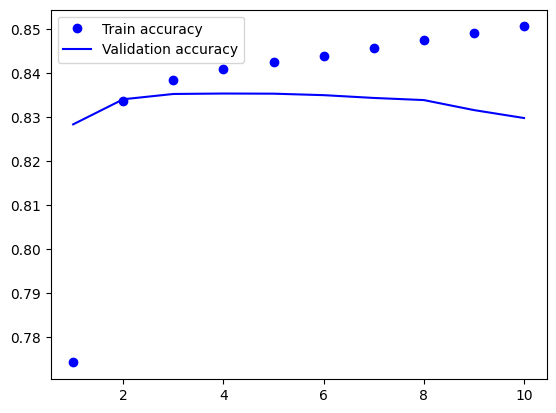

In [ ]:
eval_metric(history, 'accuracy')

In [ ]:
results = emb_model.evaluate(X_valid_emb, y_valid_emb)

1871/1871 [==============================] - 6s 3ms/step - loss: 0.3989 - accuracy: 0.8298


In [ ]:
y_pred = emb_model.predict(X_valid_emb)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_valid_emb
y_true = np.argmax(y_true, axis=1)
from sklearn.metrics import classification_report
print('Classification report for Model 2a:')
print(classification_report(y_true, y_pred))

1871/1871 [==============================] - 3s 1ms/step
Classification report for Model 2a:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     31758
           1       0.84      0.79      0.81     28096

    accuracy                           0.83     59854
   macro avg       0.83      0.83      0.83     59854
weighted avg       0.83      0.83      0.83     59854



In [ ]:
NB_START_EPOCHS = 20
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))

emb_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
history = emb_model.fit(X_train_emb, 
                        y_train_emb, 
                        epochs = NB_START_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        validation_data = (X_valid_emb, y_valid_emb), 
                        verbose = 0)

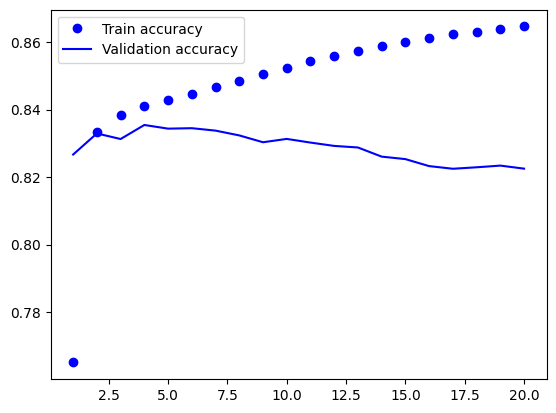

In [ ]:
eval_metric(history, 'accuracy')

In [ ]:
results = emb_model.evaluate(X_valid_emb, y_valid_emb)

1871/1871 [==============================] - 5s 3ms/step - loss: 0.4291 - accuracy: 0.8225


In [ ]:
y_pred = emb_model.predict(X_valid_emb)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_valid_emb
y_true = np.argmax(y_true, axis=1)
from sklearn.metrics import classification_report
print('Classification report for Model 2a:')
print(classification_report(y_true, y_pred))

1871/1871 [==============================] - 3s 1ms/step
Classification report for Model 2a:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     31758
           1       0.86      0.75      0.80     28096

    accuracy                           0.82     59854
   macro avg       0.83      0.82      0.82     59854
weighted avg       0.83      0.82      0.82     59854



In [ ]:
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import LSTM

In [ ]:
NB_START_EPOCHS = 10
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(Bidirectional(LSTM(128)))
emb_model.add(BatchNormalization())
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))

emb_model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = emb_model.fit(X_train_emb, 
                        y_train_emb, 
                        epochs = NB_START_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        validation_data = (X_valid_emb, y_valid_emb), 
                        verbose = 0)

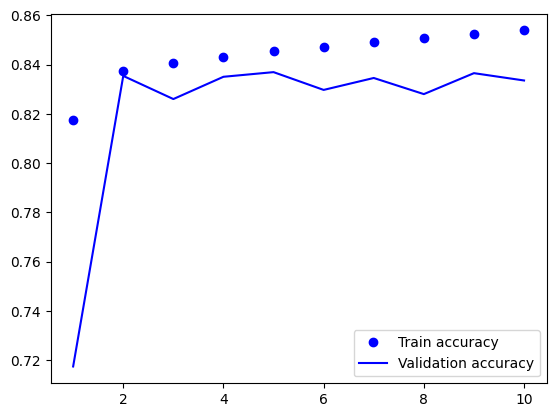

In [ ]:
eval_metric(history, 'accuracy')

In [ ]:
results = emb_model.evaluate(X_valid_emb, y_valid_emb)

1871/1871 [==============================] - 9s 5ms/step - loss: 0.3882 - accuracy: 0.8335


In [ ]:
y_pred = emb_model.predict(X_valid_emb)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_valid_emb
y_true = np.argmax(y_true, axis=1)
from sklearn.metrics import classification_report
print('Classification report for Model 2c:')
print(classification_report(y_true, y_pred))

1871/1871 [==============================] - 6s 3ms/step
Classification report for Model 2c:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     31758
           1       0.86      0.77      0.81     28096

    accuracy                           0.83     59854
   macro avg       0.84      0.83      0.83     59854
weighted avg       0.84      0.83      0.83     59854



In [ ]:
NB_START_EPOCHS = 20
emb_model = models.Sequential()
emb_model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
emb_model.add(Bidirectional(LSTM(128)))
emb_model.add(BatchNormalization())
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(2, activation='softmax'))

emb_model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
history = emb_model.fit(X_train_emb, 
                        y_train_emb, 
                        epochs = NB_START_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        validation_data = (X_valid_emb, y_valid_emb), 
                        verbose = 0)

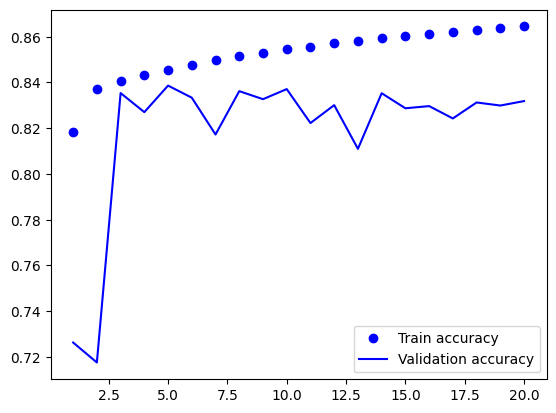

In [ ]:
eval_metric(history, 'accuracy')

In [ ]:
results = emb_model.evaluate(X_valid_emb, y_valid_emb)

1871/1871 [==============================] - 9s 5ms/step - loss: 0.3982 - accuracy: 0.8319


In [ ]:
y_pred = emb_model.predict(X_valid_emb)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_valid_emb
y_true = np.argmax(y_true, axis=1)
from sklearn.metrics import classification_report
print('Classification report for Model 2c:')
print(classification_report(y_true, y_pred))

1871/1871 [==============================] - 6s 3ms/step
Classification report for Model 2c:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     31758
           1       0.86      0.77      0.81     28096

    accuracy                           0.83     59854
   macro avg       0.84      0.83      0.83     59854
weighted avg       0.83      0.83      0.83     59854



In [ ]:
NB_START_EPOCHS = 3
emb_model2 = models.Sequential()
emb_model2.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
emb_model2.add(Bidirectional(LSTM(128)))
emb_model2.add(BatchNormalization())
emb_model2.add(layers.Flatten())
emb_model2.add(layers.Dense(2, activation='softmax'))
emb_model2.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
history = emb_model.fit(X_train_emb, 
                        y_train_emb, 
                        epochs = NB_START_EPOCHS, 
                        batch_size = BATCH_SIZE, 
                        validation_data = (X_valid_emb, y_valid_emb), 
                        verbose = 0)

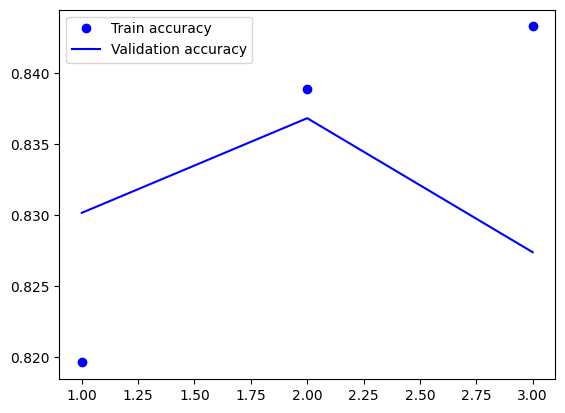

In [ ]:
eval_metric(history, 'accuracy')

In [ ]:
results = emb_model2.evaluate(X_valid_emb, y_valid_emb)

1871/1871 [==============================] - 9s 5ms/step - loss: 0.4093 - accuracy: 0.8274


In [ ]:
y_pred = emb_model2.predict(X_valid_emb)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_valid_emb
y_true = np.argmax(y_true, axis=1)
from sklearn.metrics import classification_report
print('Classification report for Model 2b:')
print(classification_report(y_true, y_pred))

1871/1871 [==============================] - 6s 3ms/step
Classification report for Model 2b:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85     31758
           1       0.90      0.71      0.79     28096

    accuracy                           0.83     59854
   macro avg       0.84      0.82      0.82     59854
weighted avg       0.84      0.83      0.82     59854

